In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Подавление предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Предобработка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


##### Пропусков нет, названия столбцов и типы данных изменять не нужно.

#### Дубликаты:

In [5]:
df.duplicated().sum()

0

##### Явных дубликатов нет. Неявных дубликатов быть не может так как все значения количественные.

#### Выбросы:

In [6]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Потенциальные признаки в которых есть выбросы:
- creatinine_phosphokinase,
- ejection_fraction,
- platelets,
- serum_creatinine

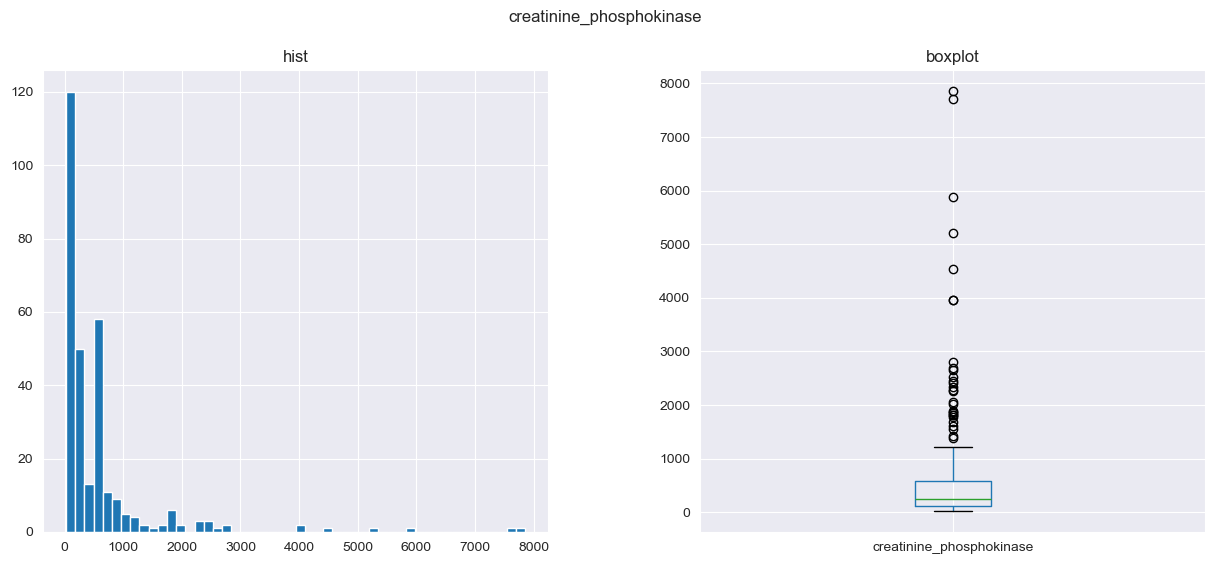

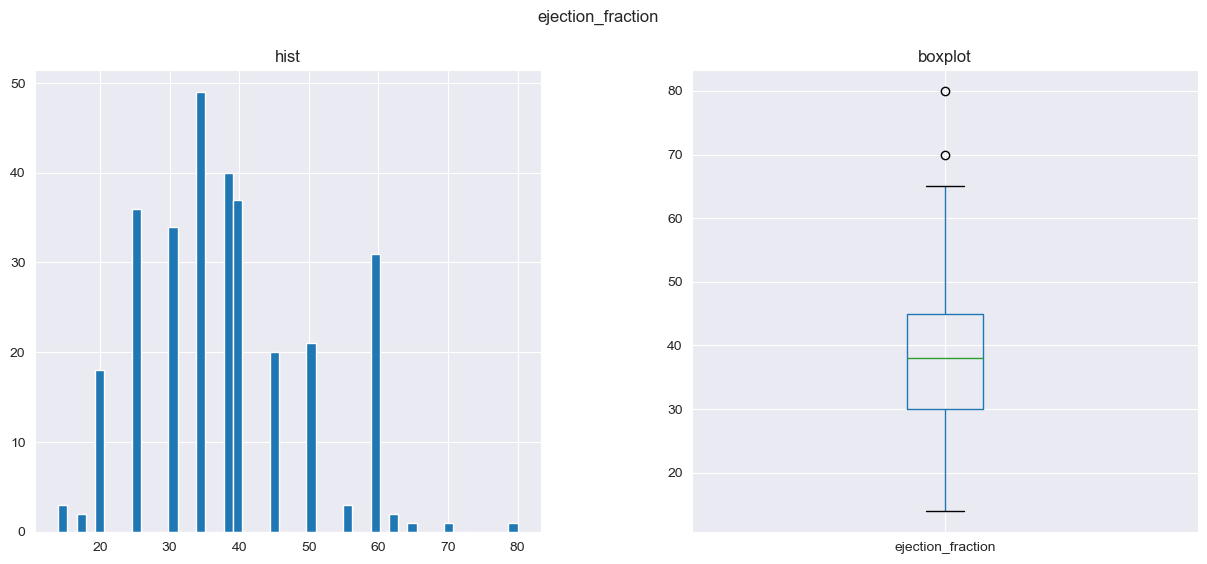

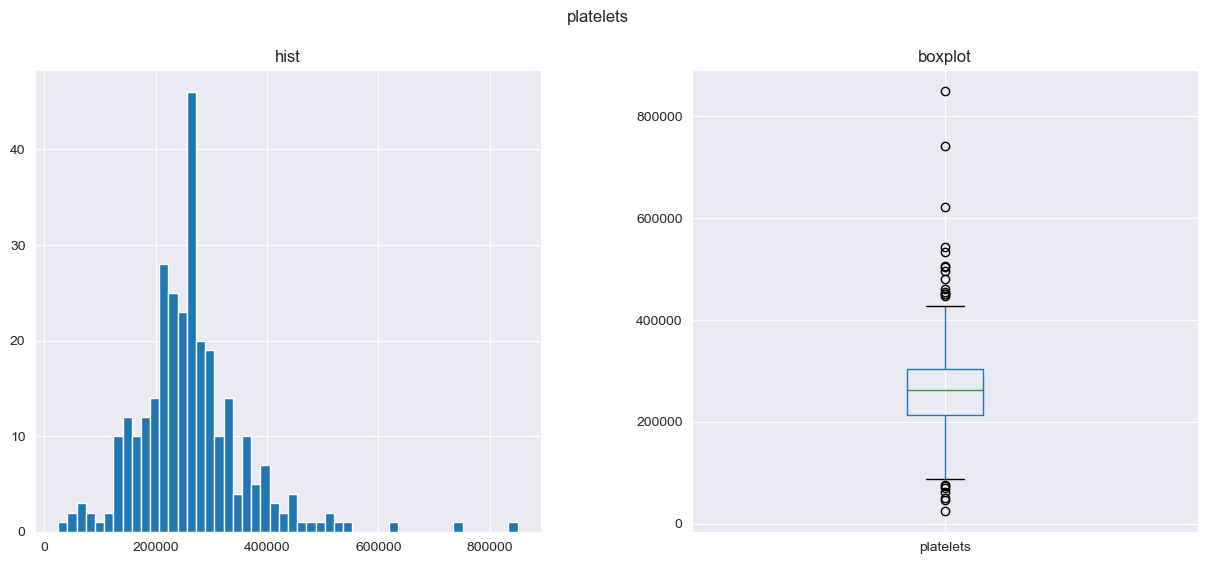

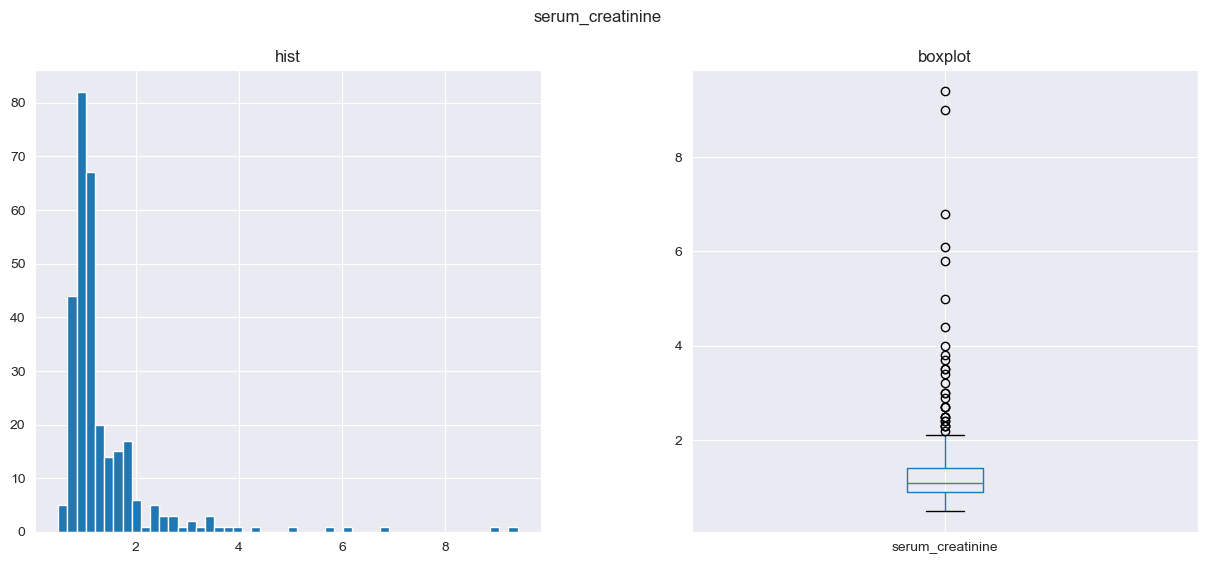

In [7]:
for i in ["creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine"]:
    fig, ax = plt.subplots(1, 2, figsize = (15,6))
    fig.suptitle(i)

    df.hist(i, bins = 50, ax = ax[0])
    df.boxplot(i, ax = ax[1])

    ax[0].set_title("hist")
    ax[1].set_title("boxplot")

Нормы:
- creatinine_phosphokinase: 25-300,
- ejection_fraction: 50% и выше,
- platelets: 150 000 - 450 000,
- serum_creatinine: 0.6 - 1.5

- creatinine_phosphokinase: больше 300 это уже не норма, а больше 3000 это уже выбросы,
- ejection_fraction: тут явных выбросов нет,
- platelets: надо посмотреть более детально на гистограмме значения меньше 100 000,
- serum_creatinine: более менее похоже на то, что выбросов нет

array([[<Axes: title={'center': 'platelets'}>]], dtype=object)

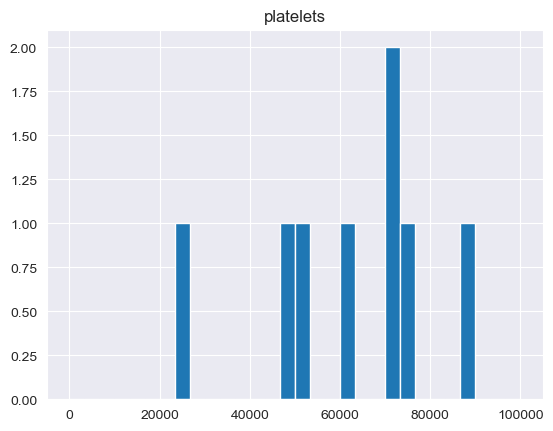

In [8]:
df.hist('platelets', bins = 30, range = (0, 100000))

In [9]:
df[df["platelets"] <= 80000]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
15,82.0,1,379,0,50,0,47000.0,1.3,136,1,0,13,1
163,50.0,1,2334,1,35,0,75000.0,0.9,142,0,0,126,1
167,59.0,0,66,1,20,0,70000.0,2.4,134,1,0,135,1
200,63.0,1,1767,0,45,0,73000.0,0.7,137,1,0,186,0
230,60.0,0,166,0,30,0,62000.0,1.7,127,0,0,207,1
277,70.0,0,582,1,38,0,25100.0,1.1,140,1,0,246,0
281,70.0,0,582,0,40,0,51000.0,2.7,136,1,1,250,0


У одного человека (id = 277) слишком мало тромбоцитов в крови (25100 мг/дл), что делает эту запись похожей на выброс, но остальные столбцы не похожи на выбросы поэтому оставим

##### Теперь посмотрим на столбец **creatinine_phosphokinase**

In [10]:
df[df["creatinine_phosphokinase"] >= 3000]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
1,55.0,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
52,60.0,0,3964,1,62,0,263358.03,6.80,146,0,0,43,1
60,45.0,0,7702,1,25,1,390000.00,1.00,139,1,0,60,1
72,85.0,0,5882,0,35,0,243000.00,1.00,132,1,1,72,1
103,42.0,0,5209,0,30,0,226000.00,1.00,140,1,1,87,0
134,81.0,0,4540,0,35,0,231000.00,1.18,137,1,1,107,0
171,52.0,0,3966,0,40,0,325000.00,0.90,140,1,1,146,0


Остальные столбцы в пределах нормы, поэтому удалять данные не будем

# Построение модели

#### Поделим датасет на валидационную, обучающую и тестовую в соотнешении 20% и 60% и 20%

In [11]:
features_train, features_test, target_train, target_test = train_test_split(df.drop("DEATH_EVENT", axis=1), df["DEATH_EVENT"], random_state=1, test_size=0.4)
features_val, features_test, target_val, target_test = train_test_split(features_test, target_test, random_state=1, test_size=0.5)

In [12]:
print("Длина тестовой выборки (в процентах): ", len(features_test)/len(df)*100)
print("Длина валидационной выборки: ", len(features_val)/len(df)*100)
print("Длина обучающей выборки: ", len(features_train)/len(df)*100)

Длина тестовой выборки (в процентах):  20.066889632107024
Длина валидационной выборки:  20.066889632107024
Длина обучающей выборки:  59.86622073578596


In [13]:
target_test.head()

292    0
150    1
139    0
289    0
38     0
Name: DEATH_EVENT, dtype: int64

#### Масштабирование признаков:

In [14]:
numeric = features_train.dtypes[features_train.dtypes == "int64"].index
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])

In [15]:
features_train.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
33,50.0,1.075466,-0.403217,1.177568,-0.680006,-0.782696,302000.0,1.2,0.344794,-1.373716,-0.665994,-1.301785
93,60.0,1.075466,-0.407579,-0.849208,-1.095720,-0.782696,210000.0,1.7,-0.335921,0.727952,-0.665994,-0.607612
219,55.0,-0.929830,-0.034203,1.177568,-0.264292,1.277636,371000.0,0.7,0.798604,-1.373716,-0.665994,0.898613


##### Проверим баланс классов:

In [16]:
df["DEATH_EVENT"].value_counts(normalize=True)*100

DEATH_EVENT
0    67.892977
1    32.107023
Name: proportion, dtype: float64

##### Получается на одну 1 приходятся два 0. Посмотрим какие варианты алгоритма борьбы с дисбалансом классов подойдут моделькам:

In [17]:
def up_sample(features, target, repeat):
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]

    features_up = pd.concat([features_one]*repeat + [features_zero])
    target_up = pd.concat([target_one]*repeat + [target_zero])

    return shuffle(features_up, target_up, random_state=1)

def down_sample(features, target, freq):
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]

    features_down = pd.concat([features_zero.sample(frac = freq, random_state = 1)] + [features_one])
    target_down = pd.concat([target_zero.sample(frac = freq, random_state = 1)] + [target_one])

    return shuffle(features_down, target_down, random_state=1)

In [18]:
# Imbalanced
res_imb = []
for i in [RandomForestClassifier(random_state=1), DecisionTreeClassifier(random_state=1), LogisticRegression(random_state=1, max_iter=10000)]:
    model = i
    model.fit(features_train, target_train)
    f1 = f1_score(target_val, model.predict(features_val))
    recall = recall_score(target_val, model.predict(features_val))
    roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:,1])
    res_imb.append({
        "Model": model.__class__.__name__,
        "F1_imb": f1,
        "Roc-Auc_imb": roc_auc,
        "Recall_imb": recall
    })
res_imb = pd.DataFrame(res_imb)


# Balanced
res_balanced = []
models = [RandomForestClassifier(random_state=1, class_weight="balanced"),
          DecisionTreeClassifier(random_state=1, class_weight="balanced"),
          LogisticRegression(random_state=1, class_weight="balanced", max_iter=1000)]

for i in models:
    model = i
    model.fit(features_train, target_train)
    f1 = f1_score(target_val, model.predict(features_val))
    recall = recall_score(target_val, model.predict(features_val))
    roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:,1])
    res_balanced.append({
        "Model": model.__class__.__name__,
        "F1_bld": f1,
        "Roc-Auc_bld": roc_auc,
        "Recall_bld": recall
    })

res_bld = pd.DataFrame(res_balanced)
total = res_imb.merge(res_bld, on="Model")


# up sample
features_train_up, target_train_up = up_sample(features_train, target_train, 2)

print(f"UpSampling\nБыло: {features_train.shape[0]}\n"
      f"Стало: {features_train_up.shape[0]}\n"
      f"{target_train_up.value_counts()}")

res_up = []
models = [RandomForestClassifier(random_state=1),
          DecisionTreeClassifier(random_state=1),
          LogisticRegression(random_state=1, max_iter=1000)]

for i in models:
    model = i
    model.fit(features_train_up, target_train_up)
    f1 = f1_score(target_val, model.predict(features_val))
    recall = recall_score(target_val, model.predict(features_val))
    roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:, 1])
    res_up.append({
        "Model": model.__class__.__name__,
        "F1_up": f1,
        "Roc-Auc_up": roc_auc,
        "Recall_up": recall
    })
res_up = pd.DataFrame(res_up)
total = total.merge(res_up, on="Model")


# down sampling
features_train_down, target_train_down = down_sample(features_train, target_train, 0.5)

print(f"\nDownSampling\nБыло: {features_train.shape[0]}\n"
      f"Стало: {features_train_down.shape[0]}\n"
      f"{target_train_down.value_counts()}")

res_down = []

for i in models:
    model = i
    model.fit(features_train_down, target_train_down)
    f1 = f1_score(target_val, model.predict(features_val))
    recall = recall_score(target_val, model.predict(features_val))
    roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:, 1])
    res_down.append({
        "Model": model.__class__.__name__,
        "F1_down": f1,
        "Roc-Auc_down": roc_auc,
        "Recall_down": recall
    })
res_down = pd.DataFrame(res_down)
total = total.merge(res_down, on="Model")

UpSampling
Было: 179
Стало: 239
DEATH_EVENT
1    120
0    119
Name: count, dtype: int64

DownSampling
Было: 179
Стало: 120
DEATH_EVENT
1    60
0    60
Name: count, dtype: int64


In [19]:
total

,Model,F1_imb,Roc-Auc_imb,Recall_imb,F1_bld,Roc-Auc_bld,Recall_bld,F1_up,Roc-Auc_up,Recall_up,F1_down,Roc-Auc_down,Recall_down
0,RandomForestClassifier,0.750000,0.840180,0.631579,0.787879,0.844031,0.684211,0.742857,0.840180,0.684211,0.700000,0.846598,0.736842
1,DecisionTreeClassifier,0.516129,0.661746,0.421053,0.529412,0.663671,0.473684,0.571429,0.689987,0.526316,0.634146,0.732349,0.684211
2,LogisticRegression,0.000000,0.544288,0.000000,0.666667,0.827985,0.684211,0.000000,0.549422,0.000000,0.535714,0.698331,0.789474


- Решающее дерево показывает лучшие результаты при **уменьшении выборки** - f1 = 0.63. **Roc-Auc** = 0.73. **Recall** = 0.68
- Случайный лес также лучше работает при **class_weight = balanced** - f1 = 0.78. **Roc-Auc** = 0.84. **Recall** = 0.68
- Логистическая регрессия хорошо работает при **class_weight = balanced** - f1 = 0.666. **Recall** = 0.68.

Самой лучшей моделью, пока что, является случайный лес - f1 = 0.78 и roc-auc = 0.84. Recall у всех одинаковый

#### Проверим catboost:

In [20]:
res_cat = []
model = CatBoostClassifier(random_state = 1, verbose = 200)
model.fit(features_train, target_train)
f1 = f1_score(target_val, model.predict(features_val))
recall = recall_score(target_val, model.predict(features_val))
roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:,1])
res_cat.append({
    "Model": model.__class__.__name__,
    "F1_imb": f1,
    "Roc-Auc_imb": roc_auc,
    "Recall_imb": recall
})

Learning rate set to 0.004942
0:	learn: 0.6900200	total: 140ms	remaining: 2m 19s
200:	learn: 0.3140334	total: 975ms	remaining: 3.88s
400:	learn: 0.2006127	total: 1.77s	remaining: 2.65s
600:	learn: 0.1449687	total: 2.57s	remaining: 1.7s
800:	learn: 0.1081865	total: 3.46s	remaining: 860ms
999:	learn: 0.0822717	total: 4.21s	remaining: 0us


In [21]:
pd.DataFrame(res_cat)

,Model,F1_imb,Roc-Auc_imb,Recall_imb
0,CatBoostClassifier,0.727273,0.849807,0.631579


f1 меньше чем у случайного леса

## Подбор гиперпараметров

Основная метрика - recall, поэтому дополнительно будем проверять модель с помощью кросс-валидации (значение будем сохранять в переменную prec_..)

In [22]:
# par = {
#     "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
# }
# model = DecisionTreeClassifier()
# grid = GridSearchCV(model, par, cv=10, n_jobs=-1, scoring="f1")
# grid.fit(features_train_down, target_train_down)
#
# display(grid.best_score_)
# display(grid.best_params_)

In [23]:
total_res = []
def roc_cur(ml_model, features = features_val, target = target_val):
    fpr, tpr, threshold = roc_curve(target, ml_model.predict_proba(features)[:, 1])
    plt.plot([0,1], [0,1],linestyle='--')
    plt.plot(fpr, tpr)
    plt.title("Roc-кривая")

def cross_val_plot(ml_model, features, target):
    plt.plot(cross_val_score(ml_model, features, target, cv=6, scoring='recall', n_jobs=-1))
    plt.title('Показатели Recall по блокам кросс-валидации')

    plt.xticks([0, 1, 2, 3, 4, 5])

def scores(ml_model, rec_mean, features=features_val, target=target_val):
    pr = precision_score(target, ml_model.predict(features))
    rec = recall_score(target, ml_model.predict(features))
    f = f1_score(target, ml_model.predict(features))
    auc = roc_auc_score(target, ml_model.predict_proba(features)[:,1])

    total_res.append({
        "model": ml_model.__class__.__name__,
        "recall_mean": rec_mean,
        "recall": rec,
        "precision": pr,
        "f1": f,
        "roc_auc": auc
    })

In [24]:
model = LogisticRegression(random_state=1, class_weight="balanced")
model.fit(features_train, target_train)

rec_lr = cross_val_score(model, features_train, target_train, scoring="recall", cv = 6, n_jobs=-1).mean()

In [25]:
scores(model, rec_lr)

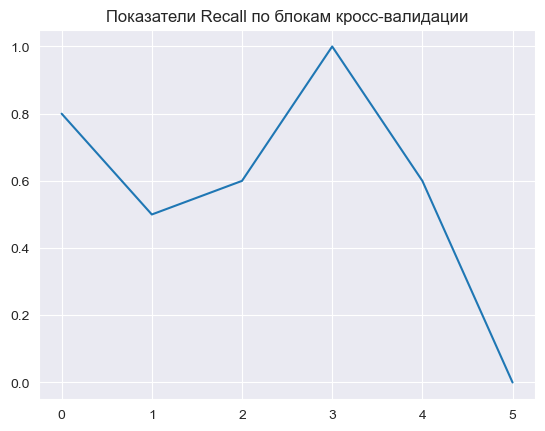

In [26]:
cross_val_plot(model, features_train, target_train)

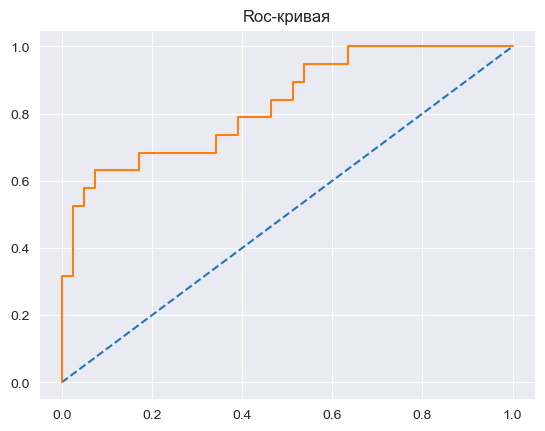

In [27]:
roc_cur(model)

In [28]:
pd.DataFrame(total_res)

,model,recall_mean,recall,precision,f1,roc_auc
0,LogisticRegression,0.583333,0.684211,0.65,0.666667,0.827985


#### **Перейдем к Decision Tree**

In [29]:
temp_best = []
for i in range(1,16):
    model = DecisionTreeClassifier(random_state=1, max_depth=i)
    model.fit(features_train_down, target_train_down)
    f1 = f1_score(target_val, model.predict(features_val))
    roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:, 1])

    temp_best.append({
        "Model": model.__class__.__name__,
        "Hyperparameters": {
            "random_state": model.random_state,
            "depth": model.max_depth
        },
        "f1": f1,
        "Roc-Auc": roc_auc
    })
pd.DataFrame(temp_best).sort_values(ascending=False, by="f1").head(3)

,Model,Hyperparameters,f1,Roc-Auc
2,DecisionTreeClassifier,"{'random_state': 1, 'depth': 3}",0.697674,0.814506
3,DecisionTreeClassifier,"{'random_state': 1, 'depth': 4}",0.682927,0.793967
4,DecisionTreeClassifier,"{'random_state': 1, 'depth': 5}",0.651163,0.772786


Улучшили значение f1, было 0.63 стало 0.697

In [30]:
model = DecisionTreeClassifier(max_depth=3, random_state=1)

rec_dt = cross_val_score(model, features_train_down, target_train_down, scoring="recall", cv = 6, n_jobs=-1).mean()
model.fit(features_train_down, target_train_down)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [31]:
scores(model, rec_dt)

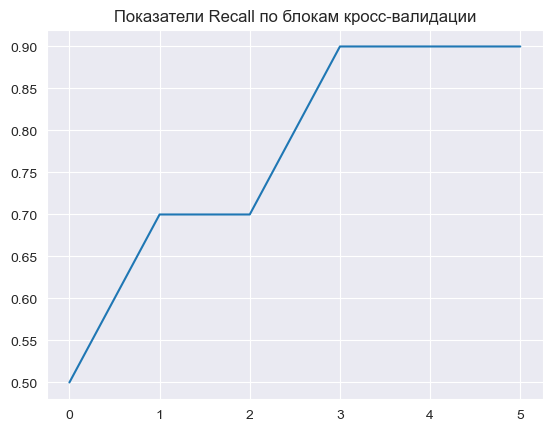

In [32]:
cross_val_plot(model, features_train_down, target_train_down)

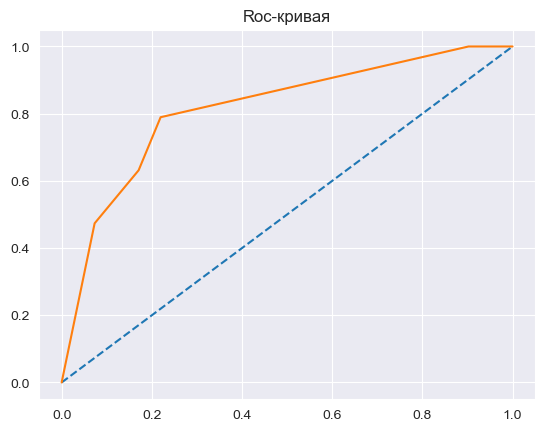

In [33]:
roc_cur(model)

In [34]:
pd.DataFrame(total_res)

,model,recall_mean,recall,precision,f1,roc_auc
0,LogisticRegression,0.583333,0.684211,0.650,0.666667,0.827985
1,DecisionTreeClassifier,0.766667,0.789474,0.625,0.697674,0.814506


По сравнению с логистической регрессии графики roc-auc и кросс-валидации по recall выглядят лучше. Recall и f1 лучше, но чуть ниже roc-auc и precision у дерева решении

#### **Перейдем к случайному лесу**

In [35]:
temp_best_rf = []
for est in range(10, 101, 10):
    for depth in range(1,16):
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=est, class_weight="balanced")
        model.fit(features_train, target_train)
        f1 = f1_score(target_val, model.predict(features_val))
        roc_auc = roc_auc_score(target_val, model.predict_proba(features_val)[:, 1])
        recall = recall_score(target_val, model.predict(features_val))

        temp_best_rf.append({
            "Model": model.__class__.__name__,
            "Hyperparameters": {
                "random_state": model.random_state,
                "depth": depth,
                "estimators": est
            },
            "f1": f1,
            "Roc-Auc": roc_auc,
            "recall": recall
        })

In [36]:
pd.DataFrame(temp_best_rf).sort_values(ascending=False, by="f1").head(3)

,Model,Hyperparameters,f1,Roc-Auc,recall
66,RandomForestClassifier,"{'random_state': 1, 'depth': 7, 'estimators': 50}",0.848485,0.820282,0.736842
100,RandomForestClassifier,"{'random_state': 1, 'depth': 11, 'estimators':...",0.823529,0.838254,0.736842
21,RandomForestClassifier,"{'random_state': 1, 'depth': 7, 'estimators': 20}",0.823529,0.818357,0.736842


Улучшили значение f1, было 0.78 стало 0.848, но при этом снизился roc-auc. Recall увеличился с 0.68 до 0.73

In [37]:
model = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=50, class_weight="balanced")
model.fit(features_train, target_train)
rec_rt = cross_val_score(model, features_train, target_train, scoring="recall", cv = 6, n_jobs=-1).mean()

In [38]:
scores(model, rec_rt)

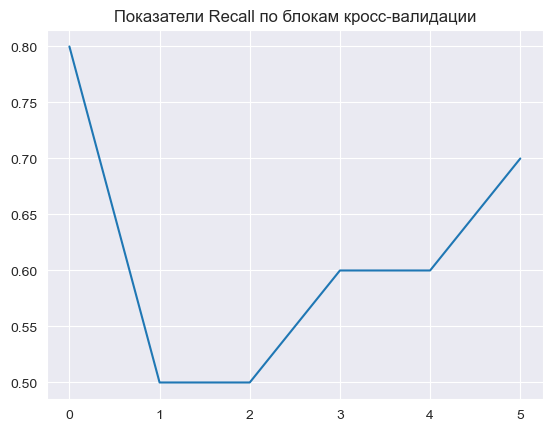

In [39]:
cross_val_plot(model, features_train, target_train)

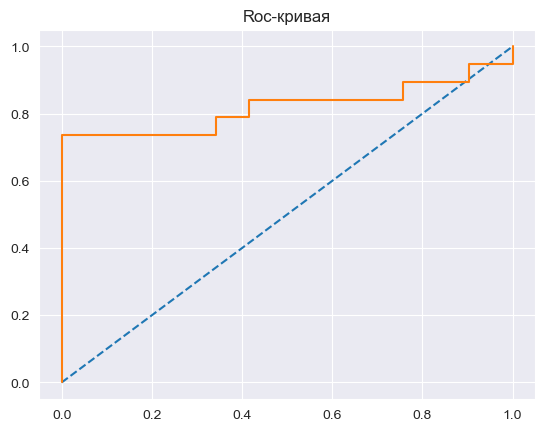

In [40]:
roc_cur(model)

In [41]:
pd.DataFrame(total_res)

,model,recall_mean,recall,precision,f1,roc_auc
0,LogisticRegression,0.583333,0.684211,0.650,0.666667,0.827985
1,DecisionTreeClassifier,0.766667,0.789474,0.625,0.697674,0.814506
2,RandomForestClassifier,0.616667,0.736842,1.000,0.848485,0.820282


Так как нам важнее recall то лучше выбрать дерево решения. У случайного лес такой большой f1 благодаря precision. Roc-Auc у всех приблизительно одинаковый

### Посмотрим на матрицу ошибок у всех моделей на тестовой выборки

In [42]:
model_rf = RandomForestClassifier(max_depth=7, n_estimators=50, random_state=1, class_weight="balanced")
model_dt = DecisionTreeClassifier(max_depth=3, random_state=1)
model_lr = LogisticRegression(random_state=1, class_weight="balanced")
model_cb = CatBoostClassifier(verbose = 0)

model_rf.fit(features_train,target_train)
model_dt.fit(features_train_down,target_train_down)
model_lr.fit(features_train,target_train)
model_cb.fit(features_train, target_train)

predict_rf = model_rf.predict(features_test)
predict_dt = model_dt.predict(features_test)
predict_lr = model_lr.predict(features_test)
predict_cb = model_cb.predict(features_test)

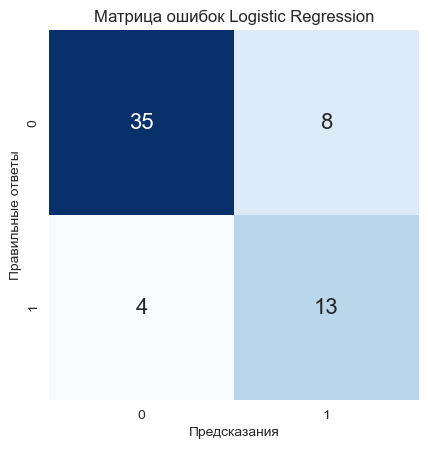

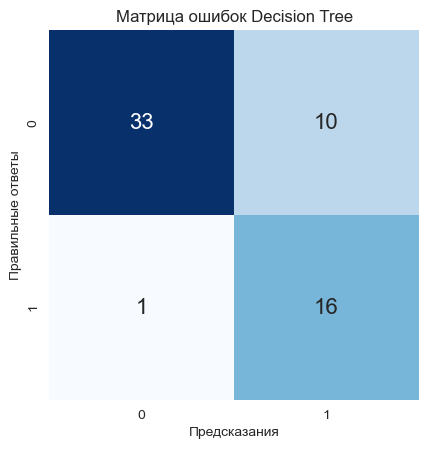

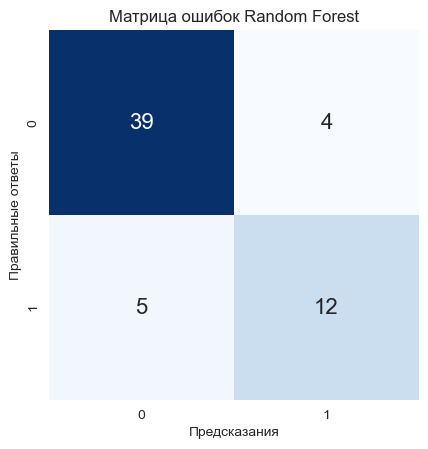

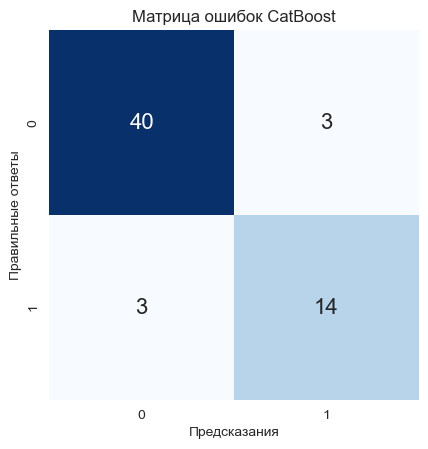

In [47]:
def conf_matrix(title_, predict_):
    sns.heatmap(confusion_matrix(target_test, predict_), cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], annot=True, annot_kws={"size": 16}, cbar=False, square=True)
    plt.title(f'Матрица ошибок {title_}')
    plt.xlabel('Предсказания')
    plt.ylabel('Правильные ответы')
    plt.show()

for title, predict in [('Logistic Regression', predict_lr), ('Decision Tree', predict_dt), ('Random Forest', predict_rf), ('CatBoost', predict_cb)]:
    conf_matrix(title, predict)

Дерево решении предсказывают отлично наш целевой показатель. Ошибка всего лишь в 1 человеке. Из 17 человек он предсказал верных 16 смертей. По сравнению с другими моделями можно заметить, что он больше отдает предпочтение единицы.

Также хорошо себя показывает catboost с 3 ошибками и у него 54 верных ответов, тогда как у дерево решении всего 49

#### Посмотрим какие важные признаки выделили модели:

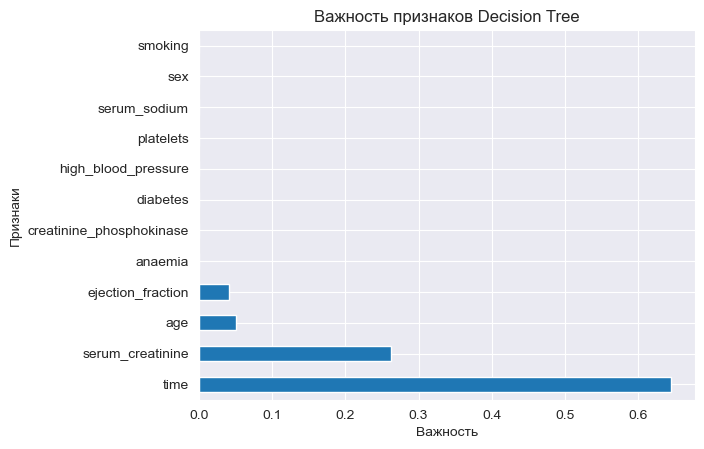

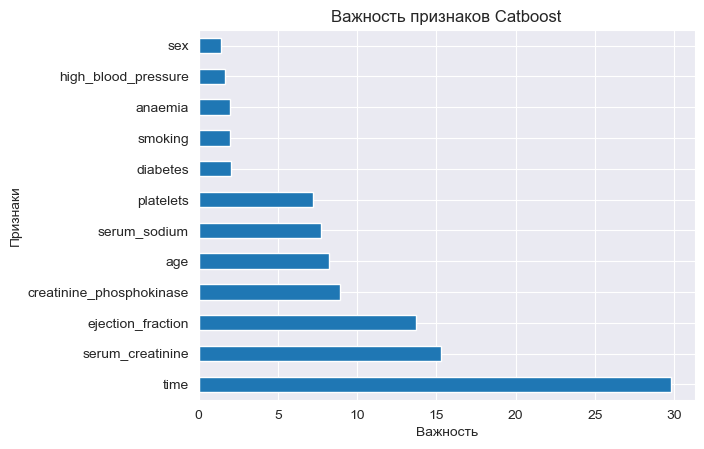

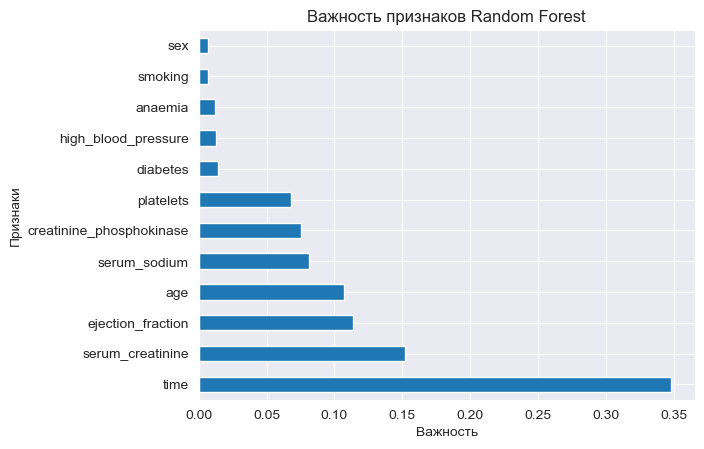

In [48]:
for model_, title_ in [(model_dt, "Decision Tree"), (model_cb, "Catboost"), (model_rf, "Random Forest")]:
    pd.Series(model_.feature_importances_, features_train.columns).nlargest(20).plot(kind='barh')
    plt.title(f'Важность признаков {title_}')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    plt.show()

Все модели показали, что важны следующие столбцы: **time, serum_creatinine, ejection_fraction, age**, а также catboost и RandomForest выделили: serum_sodium, creatinine_phosphokinase, platelets

Теперь посмотрим через функцию corr() как коррелируют между собой переменные и таргет

<Axes: >

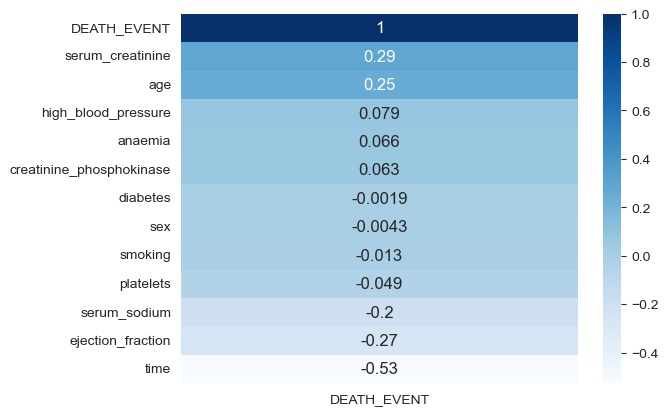

In [49]:
sns.heatmap(df.corr()[["DEATH_EVENT"]].sort_values("DEATH_EVENT", ascending=False), cmap='Blues', annot=True, annot_kws={"size":12})

Сильно положительно влияют **serum_creatinine и age**. Сильно отрицательно **time**, **ejection_fraction, serum_sodium**.

Столбцы совпадают с показаниями моделей, поэтому посмотрим на каждый столбец:

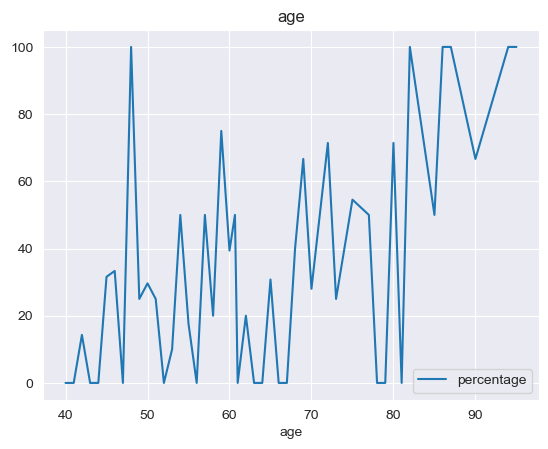

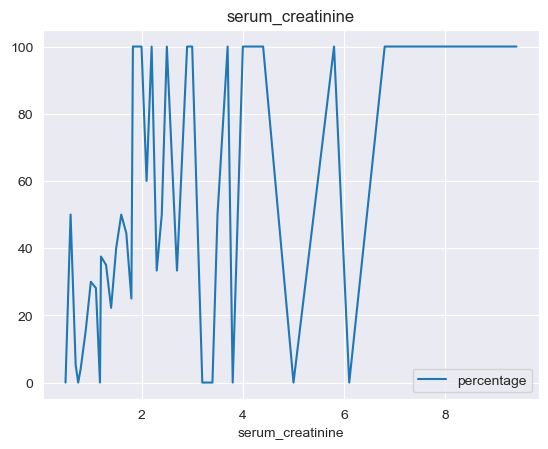

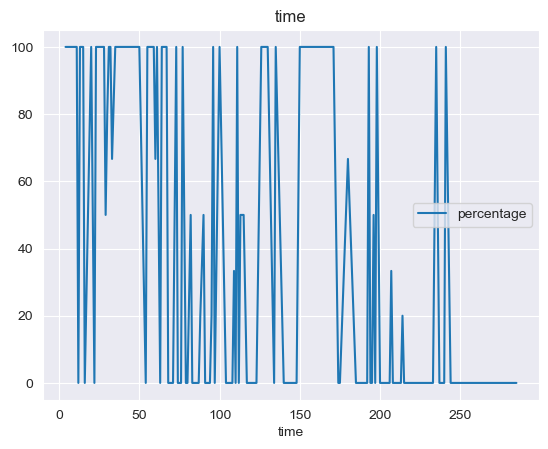

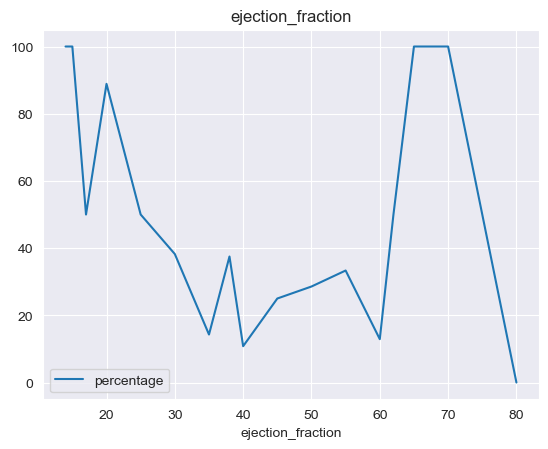

In [50]:
for i in ["age", "serum_creatinine", "time", "ejection_fraction"]:
    pv = df.pivot_table(values='DEATH_EVENT', index=i, aggfunc=['count', 'sum'])
    pv.columns = ['people_count', 'death_count']
    pv["percentage"] = pv["death_count"]/pv["people_count"]*100
    pv = pv.reset_index()
    pv.plot(x=i, y="percentage")
    plt.title(i)

По этому графику трудно увидеть зависимость (кроме столбца ejection_fraction), поэтому попробуем поделить на 6 частей упорядоченные данные и найти медиану

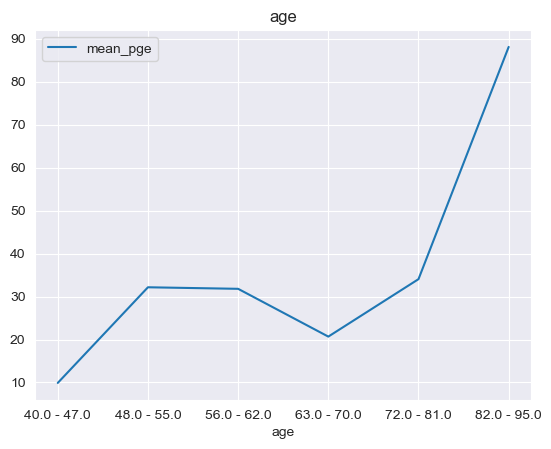

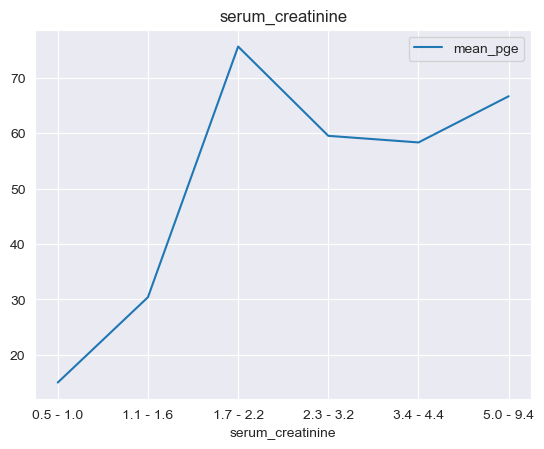

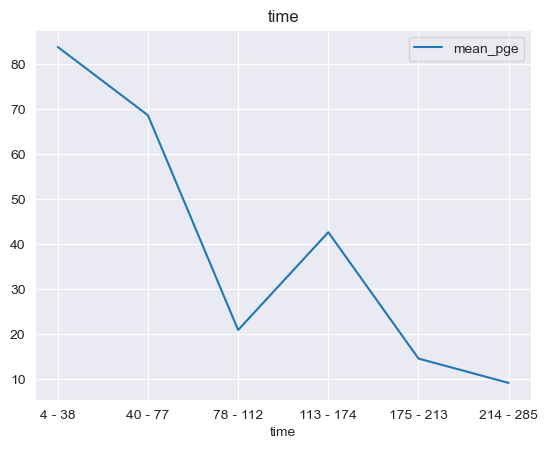

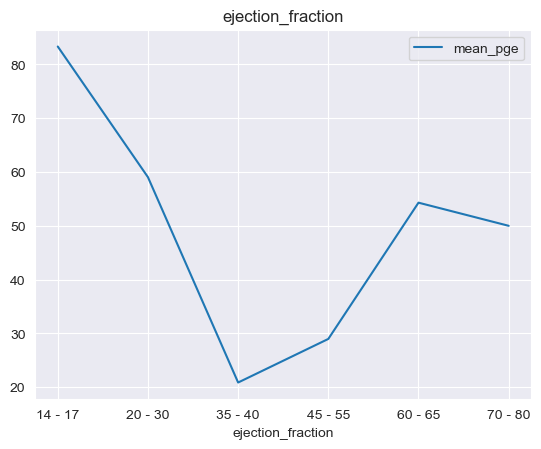

In [54]:
for i in ["age", "serum_creatinine", "time", "ejection_fraction"]:
    pv = df.pivot_table(values='DEATH_EVENT', index=i, aggfunc=['count', 'sum'])
    pv.columns = ['people_count', 'death_count']
    pv["percentage"] = pv["death_count"]/pv["people_count"]*100
    pv = pv.reset_index()
    spl = np.array_split(pv, 6)
    temp_res = []
    for j in range(6):
        res = spl[j]["percentage"].mean()
        idx = f"{spl[j][i].iloc[0]} - {spl[j][i].iloc[-1]}"
        temp_res.append({
            i: idx,
            "mean_pge": res
        })
    temp = pd.DataFrame(temp_res)
    temp.plot(x=i, y="mean_pge")
    plt.title(i)

Перед выводами еще раз вспомним нормы:

- ejection_fraction: 50%-55%,
- serum_creatinine: 0.6 - 1.5

По графикам видно:
- **age**: после 70 лет идет рост процента смертей
- **serum_creatinine**: у людей больше 1.6 mg/dL - процент смертей растет до 60-70%
- **time**: видно, что, у тех, кто исследуется больше 80 дней, вероятность умереть меньше 40%
- **ejection_fraction**: вероятность умереть у людей с откачкой крови меньше 35% составляет 60-80%, также у кого больше 55% откачки крови составляет 50%

# Вывод


- В качестве основной модели следует выбрать **дерево решений** с показателем recall больше 0,75. На тестовой выборки модель из 17 смертей предсказала верно 16
- Показания важности у функции corr и модели почти идентичны. Это столбцы: "age", "serum_creatinine", "time", "ejection_fraction"
- "age", "serum_creatinine" имеют сильно положительную связь с целевым показателем, а "time", "ejection_fraction" имею обратную связь

# Сравнение дерево решении с catboost

In [55]:
model_dt = DecisionTreeClassifier(max_depth=3, random_state=1)
model_cb = CatBoostClassifier(verbose = 0)

model_dt.fit(features_train_down, target_train_down)
model_cb.fit(features_train, target_train)

predict_dt = model_dt.predict(features_test)
predict_cb = model_cb.predict(features_test)

f1_cb = f1_score(target_test, predict_cb)
f1_dt = f1_score(target_test, predict_dt)

roc_auc_cb = roc_auc_score(target_test, model_cb.predict_proba(features_test)[:, 1])
roc_auc_dt = roc_auc_score(target_test, model_dt.predict_proba(features_test)[:, 1])

recall_cb = recall_score(target_test, predict_cb)
recall_dt = recall_score(target_test, predict_dt)
tem = []
tem.append({
    "f1_dt": f1_dt,
    "f1_cb": f1_cb,
    "Roc-Auc_dt": roc_auc_dt,
    "Roc-Auc_cb": roc_auc_cb,
    "recall_dt": recall_dt,
    "recall_cb": recall_cb
})

In [56]:
pd.DataFrame(tem)

,f1_dt,f1_cb,Roc-Auc_dt,Roc-Auc_cb,recall_dt,recall_cb
0,0.744186,0.823529,0.919289,0.953488,0.941176,0.823529


#### Пусть catboost выигрывает по roc-auc и f1, но у дерево решении **recall 0.94**